# Validation of method

### Table of contents

1. [**Heteroscedastic GP**](#hetero)
3. [**Renewal process GP**](#renewal)
4. [**GP-GLM**](#gpglm)

##### Description
This notebook contains code for:
- Compare LVM, LVM + self-coupling, full GLM coupling to explain correlations
- Neural data is synthetic Gaussian place field population with low dimensional correlations and real place field data

In [21]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
sys.path.append("..")


import jax
import jax.numpy as jnp
import jax.random as jr
from jax.nn import softplus

import optax

jax.config.update('jax_platform_name', 'cpu')
#jax.config.update('jax_disable_jit', True)
jax.config.update("jax_enable_x64", True)

#import os
#if not os.path.exists('./saves'):
#    os.makedirs('./saves')


import pickle


import lib


import matplotlib.pyplot as plt
plt.style.use(['../paper.mplstyle'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Count processes

In [2]:
x_dims = 2
f_dims = 3
neurons = f_dims
tbin = 0.1  # s

jitter = 1e-5

num_samps = 10

prng_state = jax.random.PRNGKey(123)

In [3]:
len_fx = 1.*np.ones((f_dims, x_dims))  # GP lengthscale
var_f = 1.*np.ones(f_dims)  # observation noise
kern = lib.GP.kernels.SquaredExponential(f_dims, variance=var_f, lengthscale=len_fx)
mean_f = np.zeros(f_dims)


### inducing points ###
num_induc = 5
induc_locs = jax.random.normal(prng_state, shape=(f_dims, num_induc, x_dims))
prng_state, _ = jr.split(prng_state)


u_mu = 1. + 0.*jax.random.normal(prng_state, shape=(f_dims, num_induc, 1))
u_Lcov = 0.01*jnp.eye(num_induc)[None, ...].repeat(f_dims, axis=0)
prng_state, _ = jr.split(prng_state)


svgp = lib.GP.sparse.qSVGP(kern, mean_f, induc_locs, u_mu, u_Lcov, RFF_num_feats=0)

Kzz = svgp.kernel.K(svgp.induc_locs, None, False)
lambda_1, chol_Lambda_2 = lib.GP.sparse.t_from_q_svgp_moments(Kzz, u_mu, u_Lcov)


In [4]:
count_type = 'cmp'

if count_type == 'p':
    count = lib.likelihoods.factorized.Poisson(
        neurons,
        tbin,
    )
    
elif count_type == 'zip':
    alpha = np.linspace(0.0, 0.95, neurons)
    count = lib.likelihoods.factorized.ZeroInflatedPoisson(
        neurons,
        tbin,
        alpha,
    )
    
elif count_type == 'nb':
    r_inv = np.linspace(0.0, 1.5, neurons)
    count = lib.likelihoods.factorized.NegativeBinomial(
        neurons,
        tbin,
        r_inv,
    )
    
elif count_type == 'cmp':
    nu = np.linspace(0.5, 1.5, neurons)
    count = lib.likelihoods.factorized.ConwayMaxwellPoisson(
        neurons,
        tbin,
        nu,
    )

In [5]:
y = jnp.arange(0, 20)[:, None].repeat(neurons, axis=1)
f = jnp.linspace(6, 6, neurons)

log_p_y = jax.vmap(count.log_likelihood, (None, 0), 0)(f, y)

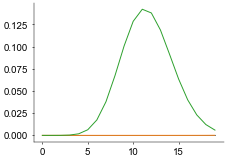

In [6]:
plt.plot(np.exp(log_p_y))
plt.show()

In [28]:
fmdl = lib.inference.gplvm.ModulatedFactorized(svgp, count)

In [29]:
ts = 100

x_eval = jnp.linspace(-2., 2., ts)[None, None, :, None]
x_eval = jnp.broadcast_to(x_eval, (num_samps, 1, ts, x_dims))

y = (np.random.randn(neurons, ts) > 3.).astype(float)


pre_rates_mean, pre_rates_cov = fmdl.evaluate_pre_conditional_rate(
    prng_state, x_eval, jitter)

y_samples, f_filtered, x_samples = fmdl.sample_prior(
    prng_state, num_samps, x_eval, time_eval=None, ini_Y=None, jitter=jitter)

## Modulated renewal process

In [22]:
x_dims = 2
f_dims = 3
neurons = f_dims
dt = 1e-3  # ms

jitter = 1e-5

num_samps = 10

prng_state = jax.random.PRNGKey(123)

filter_length = 99

In [23]:
flt_type = 'sigmoid'
if flt_type == 'sigmoid':
    alpha = np.ones((neurons, 1))
    beta = np.ones((neurons, 1))
    tau = 10*np.ones((neurons, 1))

    flt = lib.filters.FIR.SigmoidRefractory(
        alpha,
        beta,
        tau,
        filter_length,
    )
    
elif flt_type == 'rcb':
    
    a = np.ones((2, neurons, neurons))
    c = np.ones((2, neurons, neurons))
    w_h = np.random.randn(2, neurons, neurons)
    phi_h = np.ones((2, neurons, neurons))
        
    flt = lib.filters.FIR.RaisedCosineBumps(
        a,
        c,
        w_h,
        phi_h, 
        filter_length,
    )

In [24]:
len_fx = 1.*np.ones((f_dims, x_dims))  # GP lengthscale
var_f = 1.*np.ones(f_dims)  # observation noise
kern = lib.GP.kernels.SquaredExponential(f_dims, variance=var_f, lengthscale=len_fx)
mean_f = np.zeros(f_dims)


### inducing points ###
num_induc = 5
induc_locs = jax.random.normal(prng_state, shape=(f_dims, num_induc, x_dims))
prng_state, _ = jr.split(prng_state)


u_mu = 1. + 0.*jax.random.normal(prng_state, shape=(f_dims, num_induc, 1))
u_Lcov = 0.01*jnp.eye(num_induc)[None, ...].repeat(f_dims, axis=0)
prng_state, _ = jr.split(prng_state)


svgp = lib.GP.sparse.qSVGP(kern, induc_locs, u_mu, u_Lcov, RFF_num_feats=0)

Kzz = svgp.kernel.K(svgp.induc_locs, None, False)
lambda_1, chol_Lambda_2 = lib.GP.sparse.t_from_q_svgp_moments(Kzz, u_mu, u_Lcov)


In [31]:
renewal_type = 'gamma'

if renewal_type == 'gamma':
    alpha = np.linspace(0.3, 1.0, neurons)
    renewal = lib.likelihoods.renewal.Gamma(
        neurons,
        dt,
        alpha,
    )
    
elif renewal_type == 'lognorm':
    sigma = np.linspace(0.5, 1.5, neurons)
    renewal = lib.likelihoods.renewal.LogNormal(
        neurons,
        dt,
        sigma,
    )
    
elif renewal_type == 'invgauss':
    mu = np.linspace(0.5, 1.5, neurons)
    renewal = lib.likelihoods.renewal.InverseGaussian(
        neurons,
        dt,
        mu,
    )

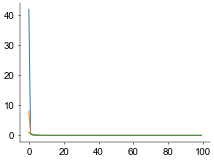

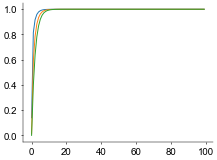

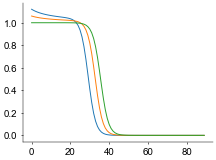

In [32]:
ISI = jnp.linspace(0.001, 50., 100)[:, None]

ll = jax.vmap(renewal.log_density)(ISI)
plt.plot(jnp.exp(ll)[:, :])
plt.show()

ll = jax.vmap(renewal.cum_density)(ISI)
plt.plot(ll[:, :])
plt.show()

ll = jax.vmap(renewal.log_hazard)(ISI)
plt.plot(np.exp(ll[10:, :]))
plt.show()

In [33]:
t_eval = jnp.linspace(0, 10, 100)
x_cond = jnp.zeros((2, f_dims, x_dims))

renewal_density = mrp.sample_instantaneous_renewal(
    prng_state, t_eval, x_cond, jitter, num_samps = 20, prior = True)

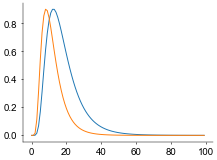

In [34]:
s = 0
n = 0

plt.plot(renewal_density[:, n, :].T)

In [35]:
ts = 100

x_eval = jnp.linspace(-2., 2., ts)[None, None, :, None]
x_eval = jnp.broadcast_to(x_eval, (num_samps, 1, ts, x_dims))

y = (np.random.randn(neurons, ts) > 0.).astype(float)[None, ...]
ini_Y = jnp.zeros((num_samps, neurons, filter_length))

log_rho_t = mrp.sample_log_conditional_intensity(
    prng_state, x_eval, jnp.concatenate((ini_Y, y.repeat(num_samps, axis=0)), axis=-1), jitter)

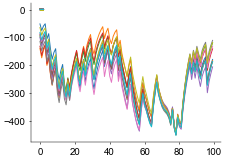

In [37]:
tr = 0
n = 0

plt.plot((log_rho_t)[:, n, :].T)
plt.plot(y[n, :])

plt.show()

In [40]:
ini_tau = jnp.zeros((num_samps, neurons))
x_samples = x_eval

y_samples, log_rho_ts = mrp.sample_prior(
    prng_state, num_samps, x_samples, ini_spikes=ini_Y, ini_tau=ini_tau, jitter=jitter)

In [41]:
y_samples, log_rho_ts = mrp.sample_posterior(
    prng_state, num_samps, x_samples, ini_spikes=ini_Y, ini_tau=ini_tau, jitter=jitter)